#  Прогнозирование заказов такси

## Содержание
1. Подготовка  
    1.1. Библиотеки и функции  
    1.2. Данные  
2. Анализ  
    2.1. Все данные  
    2.2. Дневная сезонность  
    2.3. Внутрисуточная сезонность  
3. Обучение  
    3.1. Линейная регрессия  
    3.2. Случайный лес  
    3.3. GBM  
    3.4. Выбор лучшей модели  
4. Тестирование  
5. Выводы  

**Задача:** спрогнозировать количество заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки, на основании исторических данных о заказах такси в аэропортах. Построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Подготовка

### Библиотеки и функции

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
def train_valid_test_split(data, target_col_name):
    features = data.drop(target_col_name, axis=1)
    target = data[target_col_name]

    features_train_valid, features_test, target_train_valid, target_test = train_test_split(
    features, target, shuffle=False, test_size=0.1, random_state=123)

    features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_valid, target_train_valid, shuffle=False, test_size=0.2, random_state=123)
    
    return features_train, features_valid, features_test, target_train, target_valid, target_test

In [3]:
def find_best_forest(features_train, target_train, features_valid, target_valid):
    best_model = None
    best_result = 10000
    best_est = 0
    best_depth = 0
    est_dict = {}
    
    for est in tqdm(range(10, 100, 5)):
        result_list = []
        for depth in range (1, 20, 1):
            model = RandomForestRegressor(random_state=123,
                                           n_estimators=est,
                                           max_depth=depth)
            model.fit(features_train, target_train)
            predicted = model.predict(features_valid)
            rmse = (mean_squared_error(target_valid, predicted))**0.5
            result_list.append(rmse)
            if rmse < best_result:
                best_model = model
                best_result = rmse
                best_est = est
                best_depth = depth
                
        est_dict[est] = result_list
    return best_model, best_result, best_est, best_depth, est_dict

In [4]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [5]:
def plot_decomposed_data(data):
    decomposed = seasonal_decompose(data)
    plt.figure(figsize=(6, 8))
    
    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca(), color='grey')
    plt.title('Тренд')
    
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca(), color='grey')
    plt.title('Сезонность')
    
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca(), color='grey')
    plt.title('Остаток')
    
    plt.tight_layout()

In [6]:
def plot_predictions(target_valid, predicted_valid, model_name, rmse):
    pd.Series(target_valid).plot(color='grey', figsize=(15,3));
    pd.Series(predicted_valid, index=target_valid.index).plot(color='red', alpha=.75);
    plt.legend(['валидационные метки', 'предсказания'])
    plt.title(str(model_name) + ', $RMSE$ = {:.2f}'.format(rmse));
    
def plot_predictions_test(target_test, predicted_test, model_name, rmse):
    pd.Series(target_test).plot(color='grey', figsize=(15,3));
    pd.Series(predicted_test, index=target_test.index).plot(color='red');
    plt.legend(['тестовые метки', 'предсказания'])
    plt.title(str(model_name) + ', $RMSE$ = {:.2f}'.format(rmse));

### Данные

In [7]:
data = pd.read_csv('taxi.csv', parse_dates=[0], index_col=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [9]:
print('Минимум заказов: {}, максимум заказов: {},  \
в среднем {:.2f}'.format(data.min()[0], data.max()[0], data.mean()[0]))

Минимум заказов: 0, максимум заказов: 119,  в среднем 14.07


**Вывод**: в данных 26494 наблюдений. Пропущенных значений нет.  Распределение выглядит нормальным с некоторым количеством выбросов. 

## Анализ

In [10]:
print('Первое наблюдение:', data.index[0])
print('Последнее наблюдение:', data.index[-1])

Первое наблюдение: 2018-03-01 00:00:00
Последнее наблюдение: 2018-08-31 23:50:00


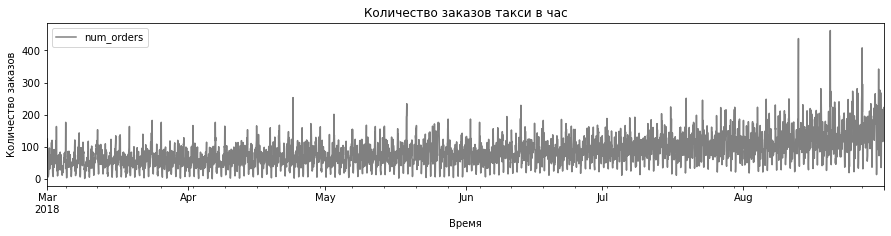

In [11]:
data = data.resample('1H').sum()
data.plot(figsize=(15,3), color='gray')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.title('Количество заказов такси в час');

In [12]:
data = data.sort_index()
print(data.index.is_monotonic)

True


### Все данные

Разложим временной ряд на тренд и сезонную компоненту. Сделаем сначала для всех данных, а потом для двух недель, чтобы проследить **дневную сезонность**, и для одного дня, чтобы увидеть, есть ли **внутрисуточная сезонность**. 

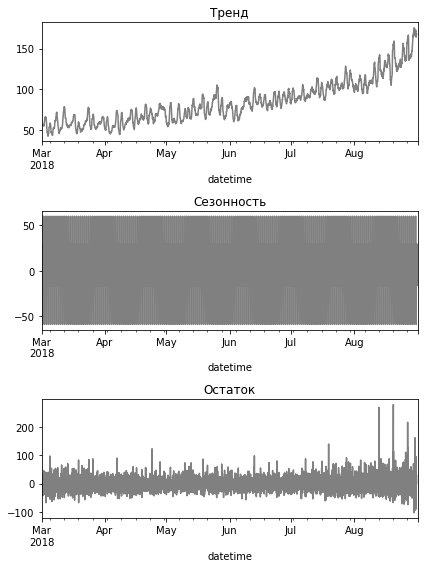

In [13]:
plot_decomposed_data(data)

### Дневная сезонность

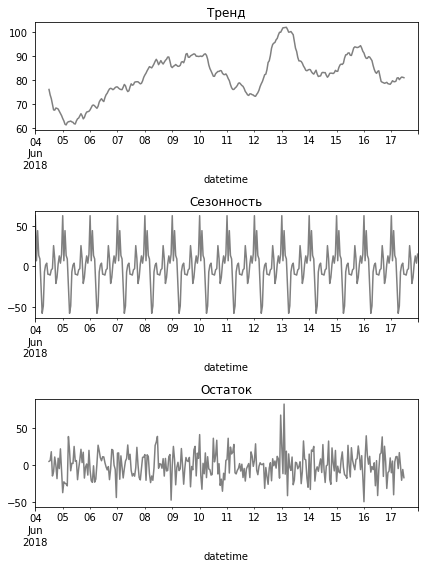

In [14]:
plot_decomposed_data(data['2018-06-04':'2018-06-17'])

### Внутрисуточная сезонность

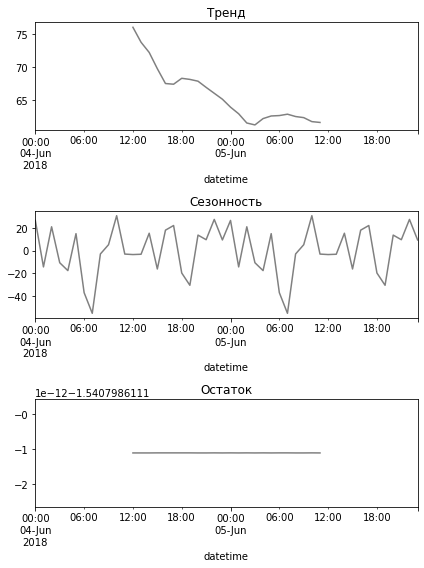

In [15]:
plot_decomposed_data(data['2018-06-04':'2018-06-05'])

**Выводы**: 

Данные расположены в хронологическом порядке. 

На первый взгляд кажется, что есть тренд на увеличение спроса на такси в течение наблюдаемого периода. Однако такой вывод мы сделать не можем, так как данные ограничены следующим временным отрезком: *2018-03-01* - *2018-08-31*.

В наблюдениях четко видна дневная сезонность: пики спроса повторяются каждые сутки.

## Обучение

Создадим признаки (*день недели, час, отстающие значения и скользящее среднее*), удалим пропущенные значения, разделим данные на тренировочную, валидационную и тестовую часть. Все результаты будем записывать в словарь *models_dict*.

In [16]:
make_features(data, 2, 24)

In [17]:
data = data.dropna()

In [18]:
data.head()

,num_orders,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-03-02 00:00:00,90,4,0,58.0,113.0,56.833333
2018-03-02 01:00:00,120,4,1,90.0,58.0,55.416667
2018-03-02 02:00:00,75,4,2,120.0,90.0,56.875000
2018-03-02 03:00:00,64,4,3,75.0,120.0,57.041667
2018-03-02 04:00:00,20,4,4,64.0,75.0,56.958333


In [19]:
(features_train, features_valid, features_test,
 target_train, target_valid, target_test) = train_valid_test_split(data, 
                                                                   'num_orders')

for i in (features_train, features_valid, features_test, 
          target_train, target_valid, target_test):
    print(i.shape)

(3161, 5)
(791, 5)
(440, 5)
(3161,)
(791,)
(440,)


In [20]:
models_dict = {}

### Линейная регрессия

In [21]:
lin_model = LinearRegression().fit(features_train, target_train)
lin_predicted_valid = lin_model.predict(features_valid)
lin_rmse = mean_squared_error(target_valid, lin_predicted_valid) ** 0.5
models_dict['Линейная регрессия'] = lin_rmse
print('RMSE линейной модели на валидационной выборке = {:.3f}'.format(lin_rmse))

RMSE линейной модели на валидационной выборке = 39.397


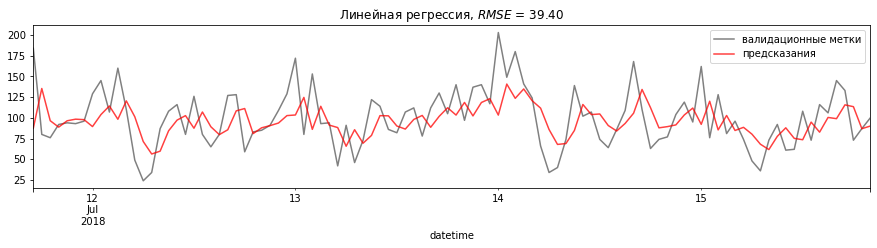

In [22]:
plot_predictions(target_valid[0:100], 
                 lin_predicted_valid[0:100], 
                 'Линейная регрессия', 
                 lin_rmse)

**Выводы**: линейная регрессия в какой-то степени предсказывает направление кривой спроса, но не угадывает пики и падения. 

### Случайный лес

**train → valid**

In [23]:
# %%time
# (forest_model, forest_rmse,
#  forest_est, forest_depth,
#  forest_dict) = find_best_forest(features_train, target_train,
#                                  features_valid, target_valid)

# print('Оптимальное количество деревьев:', forest_est)
# print('Оптимальная глубина:', forest_depth)
# # Wall time: 3min 28s

In [24]:
best_forest_model = RandomForestRegressor(random_state=123,
                                          n_estimators=40,
                                          max_depth=16).fit(features_train, target_train)

In [25]:
forest_predicted = best_forest_model.predict(features_valid)
forest_rmse = (mean_squared_error(target_valid, forest_predicted))**0.5
models_dict['Случайный лес'] = forest_rmse
print('RMSE случайного леса на валидационной выборке', round(forest_rmse, 3))

RMSE случайного леса на валидационной выборке 33.355


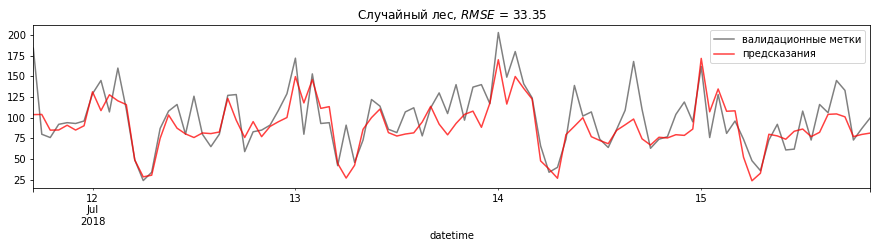

In [26]:
plot_predictions(target_valid[0:100], 
                 forest_predicted[0:100], 
                 'Случайный лес', 
                 forest_rmse)

**Выводы:** Предсказания, полученные с помощью модели случайного леса, лучше угадывают кривую спроса, чем те, что выдаёт линейная регрессия. Судя по графику, некоторые падения спроса она предсказывает довольно точно.

### GBM

In [27]:
lgb_train = lgb.Dataset(features_train, target_train, params={'verbose': -1}, free_raw_data=False)
lgb_eval = lgb.Dataset(features_valid, target_valid, reference=lgb_train, params={'verbose': -1}, free_raw_data=False)

In [28]:
tscv = TimeSeriesSplit(10).split(features_train)
param_set = {
    "learning_rate": [0.1, 0.15, 0.2, 0.5, 1.0],
    "max_depth":[3, 5, 8, 10],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "n_estimators":[5, 10, 20]
    }

In [29]:
# %%time
# gbm = lgb.LGBMRegressor()

# grid_cv = GridSearchCV(gbm, 
#                        param_grid=param_set, 
#                        scoring='neg_mean_squared_error', 
#                        n_jobs=-1, 
#                        cv=tscv, 
#                        verbose=1)

# grid_cv.fit(features_train, target_train,
#         eval_set=[(features_valid, target_valid)],
#         eval_metric='l1',
#         early_stopping_rounds=5)

## Wall time: 10min 23s

In [30]:
# print(grid_cv.best_params_)
# best_cv_params = grid_cv.best_params_

In [31]:
best_cv_params = {'criterion': 'friedman_mse',
 'learning_rate': 0.2,
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 20,
                 'verbose':-1}

In [32]:
gbm = lgb.train(best_cv_params,
                lgb_train,
                num_boost_round=100,
                valid_sets=lgb_eval,
                verbose_eval=-1)
gbm_predicted = gbm.predict(features_valid, num_iteration=gbm.best_iteration)
gbm_rmse = mean_squared_error(target_valid, gbm_predicted) ** 0.5
models_dict['GBM'] = gbm_rmse
print('RMSE GBM на валидационной выборке:', round(gbm_rmse, 2))

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
RMSE GBM на валидационной выборке: 32.84


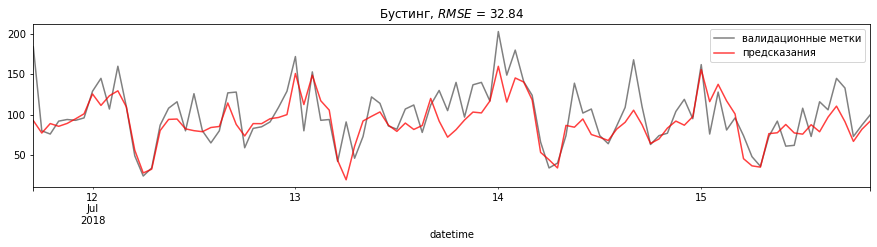

In [33]:
plot_predictions(target_valid[0:100], 
                 gbm_predicted[0:100], 
                 'Бустинг', 
                 gbm_rmse)

**Выводы:** предсказания, полученные с помощью градиентного бустинга, лучше других моделей предсказывают спады спроса, но не всегда угадывают всплески. При этом подбор параметров для этой модели оказался самым долгим.

### Выбор лучшей модели

In [34]:
results_df = pd.DataFrame.from_dict(models_dict, 
                       orient='index', 
                       columns=['rmse']).iloc[0:4].round(decimals=3)
print(results_df)

rmse_min = results_df['rmse'].min()
print('Лучшая модель:', results_df.query('rmse == @rmse_min').index[0])

                      rmse
Линейная регрессия  39.397
Случайный лес       33.355
GBM                 32.838
Лучшая модель: GBM


## Тестирование

In [35]:
features_concatenated = pd.concat([features_train, features_valid])
target_concatenated = pd.concat([target_train, target_valid])

In [36]:
lgb_concatenated = lgb.Dataset(features_concatenated, target_concatenated, free_raw_data=False)
lgb_test = lgb.Dataset(features_test, target_test, reference=lgb_train, free_raw_data=False, params={'verbose': -1})

**train + valid → test**

In [37]:
gbm_test = lgb.train(best_cv_params,
                lgb_concatenated,
                num_boost_round=100,
                valid_sets=lgb_test,
                verbose_eval=False)
gbm_predicted_test = gbm_test.predict(features_test, num_iteration=gbm_test.best_iteration)
gbm_rmse_test = mean_squared_error(target_test, gbm_predicted_test) ** 0.5

print('RMSE GBM на валидационной выборке:', round(gbm_rmse_test, 3))

[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
RMSE GBM на валидационной выборке: 44.604


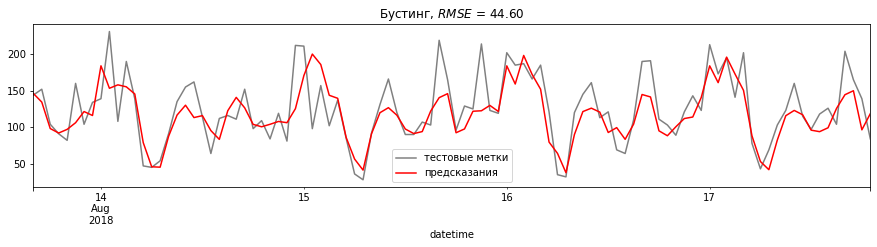

In [38]:
plot_predictions_test(target_test[0:100], 
                 gbm_predicted_test[0:100], 
                 'Бустинг', 
                 gbm_rmse_test)

## Выводы

В проекте мы спрогнозировали количество заказов такси на следующий час, чтобы привлекать больше машин в период пиковой нагрузки. Мы выделили признаки из данных, построили несколько моделей для этого предсказания и выяснили, что лучшие резлуьтаты RMSE достигаются при использовании градиентного бустинга. 

На валидационной выборке RMSE = 33.854, на тестовой RMSE = 44.604.